In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.window import Window


import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col , count , date_format

In [0]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
CUSTOMERS_DATA =   'dbfs:/FileStore/customers.csv'
DEPARTMENTS_DATA = 'dbfs:/FileStore/departments.csv'
CATEGORIES_DATA =  'dbfs:/FileStore/categories.csv'
PRODUCTS_DATA =    'dbfs:/FileStore/products.csv'
ORDERS_DATA =      'dbfs:/FileStore/orders.csv'
ORDER_ITEMS_DATA = 'dbfs:/FileStore/order_items.csv'

In [0]:
# define the schema, corresponding to a line in the csv data file for Customer
customers_schema = StructType([
    StructField('customer_id',       IntegerType(), nullable=True),
    StructField('customer_fname',    StringType(), nullable=True),
    StructField('customer_lname',    StringType(), nullable=True),
    StructField('customer_email',    StringType(), nullable=True),
    StructField('customer_password', StringType(), nullable=True),
    StructField('customer_street',   StringType(), nullable=True),
    StructField('customer_city',     StringType(), nullable=True),
    StructField('customer_state',    StringType(), nullable=True),
    StructField('customer_zipcode',  StringType(), nullable=True)])

In [0]:
departments_schema = StructType([
    StructField('department_id',   IntegerType(), nullable=True),
    StructField('department_name', StringType(), nullable=True)])

In [0]:
categories_schema = StructType([
    StructField('category_id',            IntegerType(), nullable=True),
    StructField('category_department_id', IntegerType(), nullable=True),
    StructField('category_name',          StringType(), nullable=True)])

In [0]:
products_schema = StructType([
    StructField('product_id',          IntegerType(), nullable=True),
    StructField('product_category_id', IntegerType(), nullable=True),
    StructField('product_name',        StringType(), nullable=True),
    StructField('product_description', StringType(), nullable=True),
    StructField('product_price',       FloatType(), nullable=True),
    StructField('product_image',       StringType(), nullable=True)])

In [0]:
orders_schema = StructType([
    StructField('order_id',          IntegerType(), nullable=True),
    StructField('order_date',        StringType(), nullable=True),
    StructField('order_customer_id', IntegerType(), nullable=True),
    StructField('order_status',      StringType(), nullable=True)])

In [0]:
order_items_schema = StructType([
    StructField('order_item_id',            IntegerType(), nullable=True),
    StructField('order_item_order_id',      IntegerType(), nullable=True),
    StructField('order_item_product_id',    IntegerType(), nullable=True),
    StructField('order_item_quantity',      IntegerType(), nullable=True),
    StructField('order_item_subtotal',      FloatType(), nullable=True),
    StructField('order_item_product_price', FloatType(), nullable=True)])

In [0]:
# Load data
customers_df = spark.read.csv(path=CUSTOMERS_DATA, schema=customers_schema)
customers_df.show()

departments_df = spark.read.csv(path=DEPARTMENTS_DATA, schema=departments_schema)
departments_df.show()

categories_df = spark.read.csv(path=CATEGORIES_DATA, schema=categories_schema)
categories_df.show()

products_df = spark.read.csv(path=PRODUCTS_DATA, schema=products_schema)
products_df.show()

orders_df = spark.read.csv(path=ORDERS_DATA, schema=orders_schema)
orders_df.show()

order_items_df = spark.read.csv(path=ORDER_ITEMS_DATA, schema=order_items_schema)
order_items_df.show()

+-----------+--------------+--------------+--------------+-----------------+--------------------+-------------+--------------+----------------+
|customer_id|customer_fname|customer_lname|customer_email|customer_password|     customer_street|customer_city|customer_state|customer_zipcode|
+-----------+--------------+--------------+--------------+-----------------+--------------------+-------------+--------------+----------------+
|          1|       Richard|     Hernandez|     XXXXXXXXX|        XXXXXXXXX|  6303 Heather Plaza|  Brownsville|            TX|           78521|
|          2|          Mary|       Barrett|     XXXXXXXXX|        XXXXXXXXX|9526 Noble Embers...|    Littleton|            CO|           80126|
|          3|           Ann|         Smith|     XXXXXXXXX|        XXXXXXXXX|3422 Blue Pioneer...|       Caguas|            PR|           00725|
|          4|          Mary|         Jones|     XXXXXXXXX|        XXXXXXXXX|  8324 Little Common|   San Marcos|            CA|          

In [0]:
customers_df.show(5) 
departments_df.show(5)
categories_df.show(5)

+-----------+--------------+--------------+--------------+-----------------+--------------------+-------------+--------------+----------------+
|customer_id|customer_fname|customer_lname|customer_email|customer_password|     customer_street|customer_city|customer_state|customer_zipcode|
+-----------+--------------+--------------+--------------+-----------------+--------------------+-------------+--------------+----------------+
|          1|       Richard|     Hernandez|     XXXXXXXXX|        XXXXXXXXX|  6303 Heather Plaza|  Brownsville|            TX|           78521|
|          2|          Mary|       Barrett|     XXXXXXXXX|        XXXXXXXXX|9526 Noble Embers...|    Littleton|            CO|           80126|
|          3|           Ann|         Smith|     XXXXXXXXX|        XXXXXXXXX|3422 Blue Pioneer...|       Caguas|            PR|           00725|
|          4|          Mary|         Jones|     XXXXXXXXX|        XXXXXXXXX|  8324 Little Common|   San Marcos|            CA|          

In [0]:
products_df.show(5)
orders_df.show(5)
order_items_df.show(5)

+----------+-------------------+--------------------+-------------------+-------------+--------------------+
|product_id|product_category_id|        product_name|product_description|product_price|       product_image|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+
|         1|                  2|Quest Q64 10 FT. ...|               null|        59.98|http://images.acm...|
|         2|                  2|Under Armour Men'...|               null|       129.99|http://images.acm...|
|         3|                  2|Under Armour Men'...|               null|        89.99|http://images.acm...|
|         4|                  2|Under Armour Men'...|               null|        89.99|http://images.acm...|
|         5|                  2|Riddell Youth Rev...|               null|       199.99|http://images.acm...|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+
only showing top 5 

In [0]:
# customers_df.createOrReplaceTempView("customers")
# departments_df.createOrReplaceTempView("departments")
# categories_df.createOrReplaceTempView("categories")
# products_df.createOrReplaceTempView("products")
# orders_df.createOrReplaceTempView("orders")
# order_items_df.createOrReplaceTempView("order_items")

In [0]:
# Create a list of column names
columns = customers_df.columns

# # Use select() and agg() to count null values in each column
customers_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in columns]).show()


+-----------+--------------+--------------+--------------+-----------------+---------------+-------------+--------------+----------------+
|customer_id|customer_fname|customer_lname|customer_email|customer_password|customer_street|customer_city|customer_state|customer_zipcode|
+-----------+--------------+--------------+--------------+-----------------+---------------+-------------+--------------+----------------+
|          0|             0|             0|             0|                0|              0|            0|             0|               0|
+-----------+--------------+--------------+--------------+-----------------+---------------+-------------+--------------+----------------+



### Data Cleaning

In [0]:
customers_df.show(8)

+-----------+--------------+--------------+--------------+-----------------+--------------------+-------------+--------------+----------------+
|customer_id|customer_fname|customer_lname|customer_email|customer_password|     customer_street|customer_city|customer_state|customer_zipcode|
+-----------+--------------+--------------+--------------+-----------------+--------------------+-------------+--------------+----------------+
|          1|       Richard|     Hernandez|     XXXXXXXXX|        XXXXXXXXX|  6303 Heather Plaza|  Brownsville|            TX|           78521|
|          2|          Mary|       Barrett|     XXXXXXXXX|        XXXXXXXXX|9526 Noble Embers...|    Littleton|            CO|           80126|
|          3|           Ann|         Smith|     XXXXXXXXX|        XXXXXXXXX|3422 Blue Pioneer...|       Caguas|            PR|           00725|
|          4|          Mary|         Jones|     XXXXXXXXX|        XXXXXXXXX|  8324 Little Common|   San Marcos|            CA|          

In [0]:
#dropping unwanted columns
customers_df = customers_df.drop("customer_email", "customer_password")

# Show the DataFrame after removing the columns
customers_df.show(10 , truncate = False )

+-----------+--------------+--------------+---------------------------+-------------+--------------+----------------+
|customer_id|customer_fname|customer_lname|customer_street            |customer_city|customer_state|customer_zipcode|
+-----------+--------------+--------------+---------------------------+-------------+--------------+----------------+
|1          |Richard       |Hernandez     |6303 Heather Plaza         |Brownsville  |TX            |78521           |
|2          |Mary          |Barrett       |9526 Noble Embers Ridge    |Littleton    |CO            |80126           |
|3          |Ann           |Smith         |3422 Blue Pioneer Bend     |Caguas       |PR            |00725           |
|4          |Mary          |Jones         |8324 Little Common         |San Marcos   |CA            |92069           |
|5          |Robert        |Hudson        |10 Crystal River Mall      |Caguas       |PR            |00725           |
|6          |Mary          |Smith         |3151 Sleepy Q

In [0]:
orders_df.show(10,truncate=False)

+--------+---------------------+-----------------+---------------+
|order_id|order_date           |order_customer_id|order_status   |
+--------+---------------------+-----------------+---------------+
|1       |2013-07-25 00:00:00.0|11599            |CLOSED         |
|2       |2013-07-25 00:00:00.0|256              |PENDING_PAYMENT|
|3       |2013-07-25 00:00:00.0|12111            |COMPLETE       |
|4       |2013-07-25 00:00:00.0|8827             |CLOSED         |
|5       |2013-07-25 00:00:00.0|11318            |COMPLETE       |
|6       |2013-07-25 00:00:00.0|7130             |COMPLETE       |
|7       |2013-07-25 00:00:00.0|4530             |COMPLETE       |
|8       |2013-07-25 00:00:00.0|2911             |PROCESSING     |
|9       |2013-07-25 00:00:00.0|5657             |PENDING_PAYMENT|
|10      |2013-07-25 00:00:00.0|5648             |PENDING_PAYMENT|
+--------+---------------------+-----------------+---------------+
only showing top 10 rows



In [0]:
orders_df = orders_df.withColumn("order_date", date_format(col("order_date"), "yyyy-MM-dd"))
orders_df.show(10)


+--------+----------+-----------------+---------------+
|order_id|order_date|order_customer_id|   order_status|
+--------+----------+-----------------+---------------+
|       1|2013-07-25|            11599|         CLOSED|
|       2|2013-07-25|              256|PENDING_PAYMENT|
|       3|2013-07-25|            12111|       COMPLETE|
|       4|2013-07-25|             8827|         CLOSED|
|       5|2013-07-25|            11318|       COMPLETE|
|       6|2013-07-25|             7130|       COMPLETE|
|       7|2013-07-25|             4530|       COMPLETE|
|       8|2013-07-25|             2911|     PROCESSING|
|       9|2013-07-25|             5657|PENDING_PAYMENT|
|      10|2013-07-25|             5648|PENDING_PAYMENT|
+--------+----------+-----------------+---------------+
only showing top 10 rows



In [0]:
products_df.show(5,truncate=False)

# Droping the product description column
products_df = products_df.drop("product_description")
products_df.show(3)

+----------+-------------------+---------------------------------------------+-------------------+-------------+-------------------------------------------------------------------------------------+
|product_id|product_category_id|product_name                                 |product_description|product_price|product_image                                                                        |
+----------+-------------------+---------------------------------------------+-------------------+-------------+-------------------------------------------------------------------------------------+
|1         |2                  |Quest Q64 10 FT. x 10 FT. Slant Leg Instant U|null               |59.98        |http://images.acmesports.sports/Quest+Q64+10+FT.+x+10+FT.+Slant+Leg+Instant+Up+Canopy|
|2         |2                  |Under Armour Men's Highlight MC Football Clea|null               |129.99       |http://images.acmesports.sports/Under+Armour+Men%27s+Highlight+MC+Football+Cleat     |
|3   

## Data Analysis 

In [0]:
orders_df.count()

Out[21]: 68883

In [0]:
total_revenue_per_year = (orders_df.filter(col('order_status')!="CANCELED").join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id)
    .select([F.year('order_date').alias('order_year'), 'order_item_subtotal'])
    .groupBy(['order_year'])
    .agg(F.sum('order_item_subtotal').alias('tot_sales'))
    .orderBy(['order_year']))
display(total_revenue_per_year)

order_year,tot_sales
2013,1.4940106250074387E7
2014,1.8686483344932556E7


In [0]:
tot_rev_per_month_per_year = (orders_df.filter(col('order_status')!="CANCELED").join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id)
     .select([F.year('order_date').alias('order_year'), F.month('order_date').alias('order_month'), 'order_item_subtotal'])
     .groupBy(['order_year', 'order_month'])
     .agg(F.sum('order_item_subtotal').alias('tot_revenue'))
     .orderBy(['order_year', 'order_month']))

display(tot_rev_per_month_per_year)

order_year,order_month,tot_revenue
2013,7,754899.794549942
2013,8,2769236.083465576
2013,9,2866553.3851947784
2013,10,2573575.719619751
2013,11,3105843.3310375214
2013,12,2869997.9362068176
2014,1,2870834.236070633
2014,2,2712838.6335430145
2014,3,2805006.3749523163
2014,4,2758912.5239429474


In [0]:
pdf = tot_rev_per_month_per_year.toPandas()

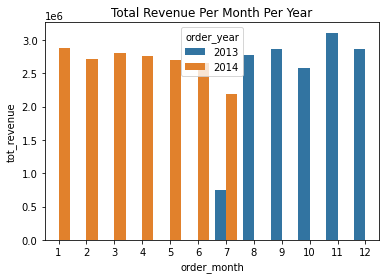

In [0]:
g = sns.barplot(x='order_month', y='tot_revenue', hue='order_year', data=pdf)
g.set_title('Total Revenue Per Month Per Year');

In [0]:
customer_purchase_history_df = customers_df.join(orders_df, customers_df.customer_id == orders_df.order_customer_id, "inner") \
    .join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id, "inner") \
    .select("customer_id", "order_date", "order_item_product_id", "order_item_subtotal")
customer_purchase_history_df.orderBy(col('customer_id')).show(10)

+-----------+----------+---------------------+-------------------+
|customer_id|order_date|order_item_product_id|order_item_subtotal|
+-----------+----------+---------------------+-------------------+
|          1|2013-12-13|                  191|             499.95|
|          2|2013-10-29|                 1014|              99.96|
|          2|2014-02-18|                  502|               50.0|
|          2|2014-02-18|                 1073|             199.99|
|          2|2014-02-18|                  957|             299.98|
|          2|2013-08-02|                 1014|              99.96|
|          2|2013-08-02|                 1014|             149.94|
|          2|2013-08-02|                  627|             199.95|
|          2|2013-08-02|                 1073|             199.99|
|          2|2013-08-02|                  365|             119.98|
+-----------+----------+---------------------+-------------------+
only showing top 10 rows



In [0]:
customer_purchase_history_df = customer_purchase_history_df.withColumn("total_purchase_amount", col("order_item_subtotal")) \
    .groupBy("customer_id").agg({"total_purchase_amount": "sum"}) \
    .withColumnRenamed("sum(total_purchase_amount)", "total_purchase_amount")
customer_purchase_history_df = customer_purchase_history_df.withColumn("total_purchase_amount", F.round("total_purchase_amount", 2))
customer_purchase_history_df = customer_purchase_history_df.orderBy(F.desc("total_purchase_amount"))
customer_purchase_history_df.show(10)

+-----------+---------------------+
|customer_id|total_purchase_amount|
+-----------+---------------------+
|        791|             10524.17|
|       9371|              9299.03|
|       8766|              9296.14|
|       1657|              9223.71|
|       2641|              9130.92|
|       1288|              9019.11|
|       3710|               9019.1|
|       4249|              8918.85|
|       5654|              8904.95|
|       5624|              8761.98|
+-----------+---------------------+
only showing top 10 rows



In [0]:
# Convert PySpark DataFrame to pandas DataFrame
pdf = customer_purchase_history_df.toPandas()
plt.figure(figsize=(10,6))
g = sns.barplot(x='customer_id', y='total_purchase_amount', hue = 'customer_id', data=pdf)
g.set_title('Total Amount purchase by each customer ');

# Show the plot
plt.show()


In [0]:
high_value_customers = customer_purchase_history_df.filter(col("total_purchase_amount") > 4000).orderBy(col("total_purchase_amount").desc())
medium_value_customers = customer_purchase_history_df.filter((col("total_purchase_amount") <= 4000) & (col("total_purchase_amount") > 2000)).orderBy(col('total_purchase_amount').desc())
low_value_customers = customer_purchase_history_df.filter(col("total_purchase_amount") <= 2000).orderBy(col('total_purchase_amount').desc())

# Print the segments
# print("High-Value Customers:")
high_value_customers.show(10)
# print("Medium-Value Customers:")
medium_value_customers.show(10)
# print("Low-Value Customers:")
low_value_customers.show(10)


In [0]:
product_sales_df = products_df.join(order_items_df, products_df.product_id == order_items_df.order_item_product_id, "inner") \
    .join(orders_df, order_items_df.order_item_order_id == orders_df.order_id, "inner") \
    .select("product_id", "order_date", "order_item_quantity", "product_name")

# Extract year and month from order date
product_sales_df = product_sales_df.withColumn("order_year", F.year("order_date")) \
    .withColumn("order_month", F.month("order_date"))

# Calculate total sales per product per month
monthly_sales_df = product_sales_df.groupBy("product_id", "order_year", "order_month") \
    .agg(F.sum("order_item_quantity").alias("total_quantity_sold"))

# Identify seasonal patterns (e.g., high sales during holidays)
# You can customize this based on your business context
seasonal_patterns_df = monthly_sales_df.groupBy("product_id", "order_month") \
    .agg(F.sum("total_quantity_sold").alias("total_monthly_sales"))

# Print the seasonal patterns
seasonal_patterns_df.show(10)

In [0]:
pandas_df = monthly_sales_df.toPandas()

# Line chart for monthly sales trends
plt.figure(figsize=(10, 6))
sns.lineplot(x="order_month", y="total_quantity_sold", hue="product_id", data=pandas_df)
plt.title("Monthly Sales Trends")
plt.xlabel("Month")
plt.ylabel("Total Quantity Sold")
plt.show()


In [0]:
df = (orders_df
      .filter((orders_df.order_status != 'CANCELED') & (orders_df.order_status != 'SUSPECTED_FRAUD'))
      .join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id, how='inner')
      .join(products_df, order_items_df.order_item_product_id == products_df.product_id, how='inner')
      .join(categories_df, products_df.product_category_id == categories_df.category_id, how='inner')
      .join(departments_df, categories_df.category_department_id == departments_df.department_id, how='inner')
      .select('department_name', F.year(orders_df.order_date).alias('order_year'), 'order_item_subtotal')
      .groupBy([departments_df.department_name, 'order_year'])
      .agg(F.sum(order_items_df.order_item_subtotal).alias('tot_revenue'))
      .orderBy('department_name', 'order_year'))
df.cache()

df.show(5)

In [0]:
(\products_df
 .select('*')
 .filter(col('product_price') == products_df.select(F.max('product_price')).collect()[0][0])
 .show())

In [0]:
popular_category_df = order_items_df.join(products_df, col("order_item_product_id") ==  col("product_id"), how='inner')\
                 .join(categories_df, col("category_id") == col("product_category_id"), how='inner')\ 
                 .groupBy('category_name') \
                 .agg(F.sum('order_item_quantity').alias('order_count')) \
                 .orderBy('order_count', ascending=False) \
                 .limit(10)
popular_category_df.show()

In [0]:
# convert it in pandas dataframe
pop_cat = popular_category_df.toPandas()
# create the pie-chart
pop_cat.plot(kind='pie', y = 'order_count', autopct='%1.1f%%', startangle=90, labels=pdf['category_name'], legend=False, title='Most popular Categories', figsize=(9, 9));

In [0]:
customers_df.show(10)